* **Author**: Adam Szady
* **Contact**: <adsz@beit.tech>

# Introduction

## tl;dr
- This solution got score of *4819* points on IBM Challenge Fall 2020 final excercise – what gives *2nd best score* (preliminary).
- It is based on a *permutation* approach.
- Optimizations from the conceptual solution to the final circuit are described step by step.
- Complete code is presented.


## The IBM Challenge
The challenge was a three week long learning and competitive quantum programming event, hosted in November 2020, by IBM. The main theme was *Programming for the Not-So-Distant Quantum Future*. Like previous challenges it consisted of the educational part, where participants at various levels of quantum proficiency learned mainly about the Grover's algorithm, QRAM, and gate synthesis (at the *Qiskit* level). The last part was dedicated to implementation and optimization of Grover search for solving particular problem. Top ten participants were asked to prepare write-ups illustrating the approach and strategy taken to reduce the cost.

# The problem
## Plot
Dr. Ryoko is in danger of being stuck forever in one of the multiverses! However, she remains surprisingly calm given the threat that looms over her. I think he believes in our success more than we do! We will do our best to help her.

To learn more about the plot, see [the video](https://www.youtube.com/watch?v=Bkk5-j6rpoM).

## Definition
We are given a 4×4 grid. 6 out of 16 cells are occupied by asteroids. The board is solvable when it is possible to choose three rows or colums, or a mix of them such that they will cover all the asteroids.

Now we are given 16 such boards and guaranteed that exactly one of them is unsolvable. Find that one (its id), using **Lov Grover's algorithm** with **one iteration**.

## Constraints
* The resulting circuit must use at most **28 qubits**.
* The initial state for Grover's algorithm must be equal probability distributions.
* With the exception of the `Unroller`, which is required for decomposing your circuit to calculate quantum costs, you are not allowed to use any existing transpiler passes nor original transpilers for making simplifications.

## Cost function
* One-qubit gates cost 1.
* Two-qubit gate (`CX`) costs 10.

Optimize the circuit, providing the lowest score possible.

## Classical preprocessing

The purpose of this excercise is to make all the computations quantum-side, with no classical preprocessing of the data. This might sound quite vague so here is a list that summarizes restrictions imposed by the Jury:

* Oracle cannot require any knowledge of what the answers are. (For example, it is not allowed to create an oracle by using a classical optimization solver to get your answers for it.)
* When mapping the board information into quantum circuit, the board information must be unchanged. Do not rearrange the asteroid positions, nor rotate, invert, swap rows and columns.
* It is not allowed to create all the solvable boards (or unsolvable boards) classically, and then checking whether a given board matches to the solvable boards (or unsolvable boards). As a rule of thumb, the problem solving should be done by the quantum circuits, not classical subroutines.

# Notebook utils
## Imports

In [1]:
from IPython.core.display import display, HTML
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.circuit import Qubit
from qiskit.circuit.library import XGate, ZGate
from qiskit.providers.aer import QasmSimulator, UnitarySimulator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.visualization import plot_histogram

from itertools import count, permutations, product
from math import log2, pi
from typing import Dict

## Matrix & circuit display

In [2]:
EPS = 1e-6
    
def format_float(v: float) -> str:
    sgn = +1 if v > 0 else -1
    if abs(v - int(v+.5*sgn)) < EPS:
        return str(int(v+.5*sgn))
    raise NotImplementedError(v)

def format_complex(v: complex) -> str:   
    if abs(v.imag) < EPS:
        if abs(v.real) < EPS:
            return '0'
        return format_float(v.real)
    if abs(v.real) < EPS:
        imf = format_float(v.imag)
        if imf == '1':
            return 'i'
        elif imf == '-1':
            return '-i'
        return f'{format_float(v.imag)}i'
    raise NotImplementedError()
    
def _swap_endianness(arr: np.ndarray) -> np.ndarray:
    num_qubits = int(log2(arr.shape[0]))
    assert arr.shape == (2**num_qubits, 2**num_qubits)

    arr = arr.reshape((2,) * 2 * num_qubits)
    arr = arr.transpose(list(reversed(range(num_qubits))) + list(reversed(range(num_qubits, 2*num_qubits))))
    arr = arr.reshape((2**num_qubits,) * 2)
    return arr

display(HTML('''<style>
.matrix { background: #0007; }
.matrix tr { background: none !important; }
.matrix td {
  height: 1.5em;
  width: 1.5em;
  font-size: 0.8em;
  line-height: 1;
  text-align: center;
  border-color: #fff3 !important;
}
.matrix td.z { opacity: 0.5 }
</style>'''))
    
def print_matrix(m):
    cells = [
        [format_complex(v) for v in row]
        for row in m
    ]
    def classes(f):
        return ['z'] if f == '0' else []
    return HTML(
        '<table class="matrix">' + 
        ''.join(
            '<tr>' +
            ''.join(f'<td class="{" ".join(classes(f))}">{f}</td>' for f in row) +
            '</tr>'
            for row in cells
        ) +
        '</table>'
    )
    
def print_unitary(qc):
    return print_matrix(_swap_endianness(execute(
        qc, backend=UnitarySimulator()).result().get_unitary()
    ))
               
def display_circuit(qc, unroll=False):
    if unroll:
        qc = PassManager(Unroller(['cx', 'h', 'z', 'x', 'u'])).run(qc)
    return qc.draw(output='mpl')

## Read & display boards

In [3]:
def read_board(spec):
    """ Just read the data into np.array with values 1: asteroid, 0: no asteroid """
    board = np.zeros((4,4), dtype=int)
    for r, c in spec:
        board[int(r), int(c)] = 1
    return board

def fhtml(board, shots=((), ()), caption=None, chosen=set()):
    row_shots, col_shots = shots
    return (
        '<div class="twr"><div class="t"><table class="t">' +
        ''.join([
            '<tr>' +
            ''.join([
                '<td class="' + ' '.join([f'x{cell}'] + (['ch'] if (r, c) in chosen else [])) +'"></td>'                
                for c, cell in enumerate(row)
            ]) +
            '</tr>'
            for r, row in enumerate(board)
        ])+
            (f'<caption>{caption}</caption>' if caption else '') +
        '</table>'+
            ''.join(f'<div class="sh r r{r}"></div>' for r in row_shots)+
            ''.join(f'<div class="sh c c{c}"></div>' for c in col_shots)+
        '</div></div>')

display(HTML('''<style>
.boards {
  text-align: center;
  display: flex;
  flex-wrap: wrap;
  align-content: center;
  justify-content: center;
}
.boards div.twr {
  display: inline-block;
  background: #00000077;
  padding: .3em;
  margin: .1em;
}
.boards table caption { caption-side: bottom; text-align:center; padding: .1em; color: white; font-size: .8em}
.boards table.t { margin: 0; border-collapse: collapse; }
.boards table.t tbody { border: 1px solid black; display: inline-block; border-collapse: collapse; }
.boards table.t tbody tr { background: transparent; }
.boards table.t td { height:20px; width:20px; border: 1px solid #333; background: #ffffffcc;}
.boards table.t td.x1{ background: #ffc77daa;}
.boards table.t td.x1.ch{ background: #983209cc;}

.boards div.t { position: relative; margin: .6em}
.boards div.t .sh {
  position: absolute;
  border: 1px solid #f5ff62;
  box-shadow: #ffe5c4 0 0 4px 1px;
}
.boards div.t .sh.r { width:87px; height:0px; left:-2px; }
.boards div.t .sh.r0 { top: 10px; }
.boards div.t .sh.r1 { top: 30px; }
.boards div.t .sh.r2 { top: 50px; }
.boards div.t .sh.r3 { top: 70px; }
.boards div.t .sh.c { height:87px; width:0px; top:-2px; }
.boards div.t .sh.c0 { left: 10px; }
.boards div.t .sh.c1 { left: 30px; }
.boards div.t .sh.c2 { left: 50px; }
.boards div.t .sh.c3 { left: 70px; }
</style>'''))
    
def show_boards(boards):
    display(HTML('<div class="boards">' +\
        ' '.join(
            fhtml(**kwargs)
            for kwargs in boards
        ) + '</div>'
    ))

## Cost function

In [4]:
COSTS: Dict[str, int] = {
    'cx': 10, 'u': 1, 'p': 1,
    'u1': 1, 'u2': 1, 'u3': 1, 
    't': 1, 'tdg': 1,
    'x': 1, 'z': 1, 'h': 1,
    'ry': 1, 
    'measure': 0,
}

def compute_cost(qc: QuantumCircuit) -> int:
    qcu = PassManager(Unroller(['cx', 'u3', 'u1', 't', 'tdg', 'u', 'p'])).run(qc)
    return sum(COSTS[op]*count for op, count in qcu.count_ops().items()) 

## Example
Let us now examine a sample problem dataset.

In [5]:
problem_set = [
    [['0', '2'], ['1', '0'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '3']],
    [['0', '0'], ['1', '1'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '1'], ['1', '3'], ['3', '2'], ['3', '3']],
    [['0', '2'], ['1', '0'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '1'], ['3', '3']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '3'], ['1', '2'], ['2', '2'], ['2', '3'], ['3', '0']],
    [['0', '3'], ['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '3'], ['2', '1'], ['2', '3'], ['3', '0']],
    [['0', '1'], ['0', '3'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '2']],
    [['0', '0'], ['1', '3'], ['2', '0'], ['2', '1'], ['2', '3'], ['3', '1']],
    [['0', '1'], ['0', '2'], ['1', '0'], ['1', '2'], ['2', '2'], ['2', '3']],
    [['0', '3'], ['1', '0'], ['1', '3'], ['2', '1'], ['2', '2'], ['3', '0']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '3'], ['3', '0'], ['3', '1']],
    [['0', '1'], ['1', '0'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '1']],
]

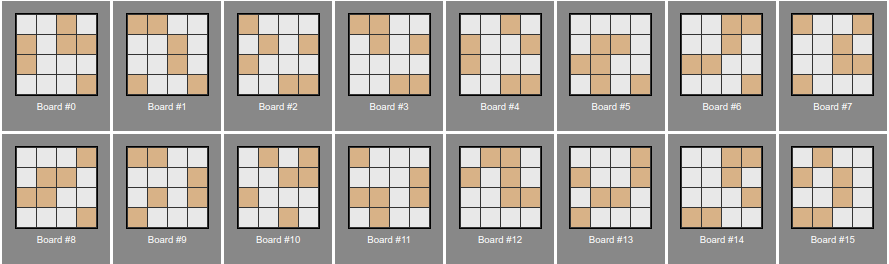

In [6]:
show_boards([
    {
        'board': read_board(board_spec),
        'caption': f'Board #{i}'
    }
    for i, board_spec in enumerate(problem_set)
])

We notice that all but one board are solvable using three shots:

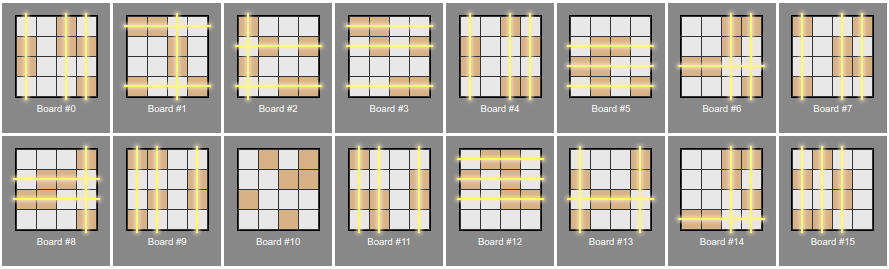

In [7]:
show_boards([
    {
        'board': read_board(board_spec),
        'caption': f'Board #{i}',
        'shots': [
            ((), (0, 2, 3)),
            ((0, 3), (2,)),
            ((1, 3), (0,)),
            ((0, 1, 3), ()),
            ((), (0, 2, 3)),
            ((1, 2, 3), ()),
            ((2,), (2, 3)),
            ((), (0, 2, 3)),
            ((1, 2), (3,)),
            ((), (0, 1, 3)),
            ((), ()),
            ((), (0, 1, 3)),
            ((0, 1, 2), ()),
            ((2,), (0, 3)),
            ((3,), (2, 3)),
            ((), (0, 1, 2)),
        ][i],
    }
    for i, board_spec in enumerate(problem_set)
])

# Solution

We utilize [Kőnig's theorem](https://tryalgo.org/en/matching/2016/08/05/konig/), which can be summarized as follows.

If from the 6 occupied places we can choose 4, such that they don't share neither rows nor columns, the board cannot be solvable no matter how hard we try. See:

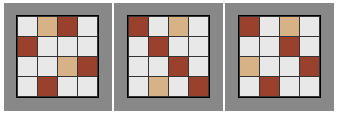

In [8]:
show_boards([
    {
        'board': read_board(['23', '10', '02', '31', '01', '22']),
        'chosen':{(2,3), (1,0), (0,2), (3,1)}
    },
    {
        'board': read_board(['00', '11', '22', '33', '02', '31']),
        'chosen':{(0,0), (1,1), (2,2), (3,3)}
    },
    {
        'board': read_board(['00', '31', '12', '23', '02', '20']),
        'chosen':{(0,0), (3,1), (1,2), (2,3)}
    },
])

What happens in the opposite case? Imagine we can choose only 3 such asteroids. In terms of graph language and Kőnig's theorem, this set is called a *(maximal) matching*. The theorem actually provides a constructive proof that we can shoot all the asteriods within 3 shots. The steps are the following:

1. Mark all rows that are not present in the matching.
2. Repeat until no changes are made:
    1. If in the current setting an asteroid **from** matching is shot, mark also its **row** for shooting.
    2. If in the current setting an asteroid **not from** matching is shot, mark also its **column** for shooting.
3. Invert the choice of rows.

The following example illustrates steps of the algorithm:

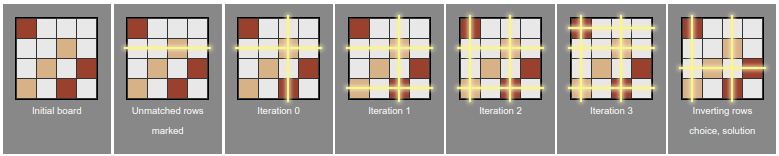

In [9]:
def konig(board_spec, matching):
    
    board = read_board(board_spec)
    boards = []    
    shrows = set()
    shcols = set()
    
    def snapshot(caption):
        boards.append({
            'board': board,
            'chosen': matching,
            'shots': (tuple(shrows), tuple(shcols)),
            'caption': caption,
        })
        
    snapshot('Initial board')
    
    for r in range(4):
        if all((r, c) not in matching for c in range(4)):
            shrows.add(r)
    snapshot('Unmatched rows marked')
    
    for i in count():
        nextshrows = set(shrows)
        nextshcols = set(shcols)
        
        for r, c in product(range(4), repeat=2):
            if board[r, c]:
                shot = r in shrows or c in shcols
                if shot:
                    if (r, c) in matching:
                        nextshrows.add(r)
                    else:
                        nextshcols.add(c)
        
        if shrows == nextshrows and shcols == nextshcols:
            break
            
        shrows, shcols = nextshrows, nextshcols
        snapshot(f'Iteration {i}')
        
    shrows = set(range(4)) - shrows
    snapshot('Inverting rows choice, solution')
                    
    return boards

show_boards(konig([(0,0), (1,2), (2,1), (2,3), (3,0), (3,2)], [(0,0), (2,3), (3,2)]))

And for yet another board, see the algorithm steps for two different initial matchings:

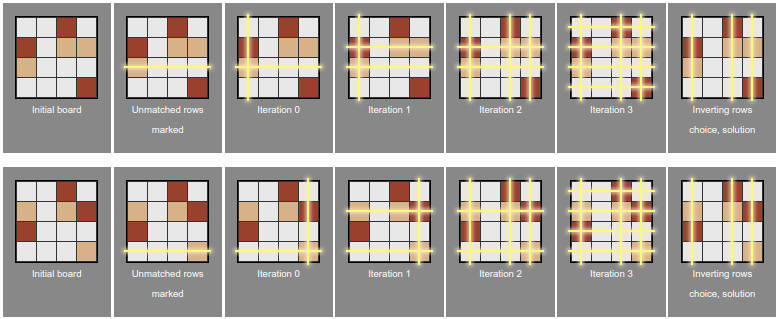

In [10]:
show_boards(konig([(0,2), (1,0), (1,2), (1,3), (2,0), (3,3)], [(0,2), (1,0), (3,3)]))
show_boards(konig([(0,2), (1,0), (1,2), (1,3), (2,0), (3,3)], [(0,2), (1,3), (2,0)]))

By the construction of the algorithm we observe the following:

1. During the algorithm, each column marking is followed by marking a row, keeping the number of selected rows+columns after the final inversion of rows choice constant (here: 3). In the case there is a marking of a column not followed by marking of a row, that implies that the initial matching provided was not maximal and tracing the rows/columns back gives us an augumenting path. That proves we get the required number of shots.
2. After the last iteration, each of element *belonging* to the matching is either shot by row and column, or none of them. Therefore, after inverting rows selection, each element from the matching is shot either by row or by column (not both). That proves that all the elements constituting the matching are shot.
3. After the last iteration, for each element *not belonging* to the matching the following holds. If it is row-shot, then it must be column-shot (by the construction of algorithm). Now by contraposition: if it is not column-shot, then it is not row-shot. After the final inversion we obtain that it is shot in both cases. That proves the remaining elements are shot as well.

More formal proof can be obtained by following Kőnig's theorem directly.

Combining the above observations we conclude that it is enough to check if there is a matching of size 4 to infer the board's unsolvability. In other words, we are going to check if there exists such permutation of columns that marked elements form a diagonal on the permuted board. And this is going to be the base of the proposed solution.

# Going quantum – sketch of the solution

In this challenge we are to implement the solution using celebrated Grover's algorithm with one iteration. Here is the sketch of the whole circuit conforming to this requirement.

* First we allocate some registers.
* As the first quantum operation we prepare an initial, equal superposition of our search space – 16 boards, using Hadamard transform on 4 qubits representing board ids.
* Next we apply an oracle, that flips the phase by $\pi$ radians of the states (boards) we look for.
* Then we use diffuser that effectively inverts the amplitude about the average of all the affected states. As a consequence it amplifies the states phased by an oracle earlier.
* After we are done with one Grover iteration, we proceed to measuring the results, hoping that the valid answer – unsolvable board – has the probability greater than the other elements.

The code is presented below. Next parts explain in details the whole implementation.

In [11]:
Q = list(range(28))  # Convenience array for addressing qubits

In [12]:
def solution_concept(problem_set):
    boards = [read_board(board_spec) for board_spec in problem_set]
    
    # Board id [0 - MSB, 3 - LSB]   
    qbid = QuantumRegister(4, name='bid')  
    
    # Buffer for the whole board (flattened, C memory order)
    qbuf = QuantumRegister(16, name='buf')  
    
    # General-purpose ancillae
    qanc = QuantumRegister(2, name='anc')
    
    # Measured answer (endianness as in `qbid`)
    cans = ClassicalRegister(4, name='c')  
    
    qc = QuantumCircuit(qbid,  qbuf, qanc, cans)                
        
    qc.h(qbid)    
    oracle_concept(qc, boards, qbid, qbuf, qanc)    
    diffuser_concept(qc, qbid, qanc)
    qc.measure(qbid, cans)
        
    return qc

## The oracle
This is the key part of the algoritm and the place where all the complexity comes from, as it must be designed to solve the particular problem. In our case it marks one of the board ids. Therefore we need to load the associated board data, mark state based on that data, and later unload the data, so that the phase change is the only effect of applying the oracle.

In [13]:
def oracle_concept(qc, boards, qbid, qbuf, qanc):  
    qram_concept(qc, boards, qbid, qanc, qbuf)        
    mark_unsolvable_concept(qc, qbuf, qanc)
    qram_concept(qc, boards, qbid, qanc, qbuf)  # Unload the data / uncompute

## QRAM loading

In [14]:
def qram_concept(qc, boards, qbid, qanc, qbuf):
    assert len(qbid) == 4
    assert len(qbuf) == 16    

    obtain4_many_concept(
        qc, boards,
        [(r, c) for r in range(4) for c in range(4)], qbid, qbuf, qanc) 

## Mark unsolvable

In this part, we assume having our data already in `qbuf`. The task, according to our solution is to detect if there is such permutation of columns for which occupied places form a diagonal, and this is equivalent to existence of matching of size 4. Here we just check all possible permutations and if we find a permutation being evidence of unsolvability of the board, we mark the state by applying Z rotation.

In [15]:
def mark_unsolvable_concept(qc, qbuf, qanc):
    assert len(qbuf) == 16
    assert len(qanc) >= 1

    permwalk = permutations_walk_concept()
    for pid, perm in enumerate(permwalk):        
        qc.ccx(qbuf[0*4 + perm[0]], qbuf[1*4 + perm[1]], qanc[0])
        qc.ccx(qbuf[2*4 + perm[2]], qbuf[3*4 + perm[3]], qanc[1])
        qc.cz(qanc[0], qanc[1])
        qc.ccx(qbuf[2*4 + perm[2]], qbuf[3*4 + perm[3]], qanc[1])
        qc.ccx(qbuf[0*4 + perm[0]], qbuf[1*4 + perm[1]], qanc[0])

For a moment we ignore the fact that there are boards with two such permutations, see images below. We will come back to this later.

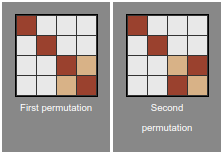

In [16]:
show_boards([
    {
        'board': read_board(['00', '11', '22', '23', '32', '33']),
        'chosen': [(0,0), (1,1), (2,2), (3,3)],
        'caption': 'First permutation',
    },
    {
        'board': read_board(['00', '11', '22', '23', '32', '33']),
        'chosen': [(0,0), (1,1), (2,3), (3,2)],
        'caption': 'Second permutation',
    },
])

We are going to walk over all the permutations in any order.

In [17]:
def permutations_walk_concept():
    return list(permutations(range(4)))

## Diffuser

It is a final step, that utilizes phase difference we prepared earlier to amplify the differing state. Inversion about the average is another name for it. Here we present the simplest implementation.

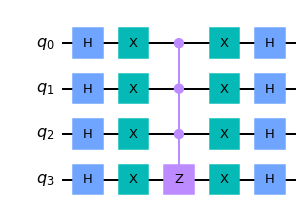

In [18]:
def diffuser_concept(qc, qbits, qanc):
    qc.h(qbits)
    qc.x(qbits)
    qc.append(ZGate().control(len(qbits) - 1), qbits)
    qc.x(qbits)
    qc.h(qbits)
    
qc = QuantumCircuit(4)
diffuser_concept(qc, Q[:4], [])
display_circuit(qc)

## Obtainator

To complete the code we need to provide the subroutine for loading the data into quantum state. This is quite straightforward. Assuming we have `qctrl` bit marked for some board id (`bid`), we `CX` with that control qubit, all the qubits in the board buffer if (conditioned classically on the input data) there is a threat coming from an asteroid at that position.

In [19]:
def obtain4_many_concept(qc, boards, coords, qbid, qbuf, qanc):
    def func(bid, qctrl):
        for (r, c), qtarget in zip(coords, qbuf):
            if boards[bid][r, c]:
                qc.cx(qctrl, qtarget)
    obtain4_walk_concept(qc, boards, func, qbid, qanc)

### Obtain walk

Again, the simplest possible solution for preparing the control ancilla.

In [20]:
def obtain4_walk_concept(qc, boards, func, qbid, qanc):
    assert len(qanc) >= 1
    
    for bid in range(16):
        def x():
            if bid & 0b0001 == 0: qc.x(qbid[3])
            if bid & 0b0010 == 0: qc.x(qbid[2])
            if bid & 0b0100 == 0: qc.x(qbid[1])
            if bid & 0b1000 == 0: qc.x(qbid[0])
            
        x()
        qc.append(XGate().control(4), qbid[:] + [qanc[0]])
        func(bid, qanc[0])
        qc.append(XGate().control(4), qbid[:] + [qanc[0]])
        x()

## Testing the solution

We have finalized the concept of the solution. Now it is the time to verify if the code works correctly.

In [21]:
def simulate(qc, title='Histogram'):
    job = execute(qc, QasmSimulator(precision='single'), shots=1000, seed_simulator=12345)

    result = job.result()
    counts_by_board = {
        int(measured[::-1].split(' ')[0], 2): count
        for measured, count in result.get_counts().items()
    }
    
    return plot_histogram(counts_by_board, bar_labels=False, title=f'{title} (cost {compute_cost(qc)})')

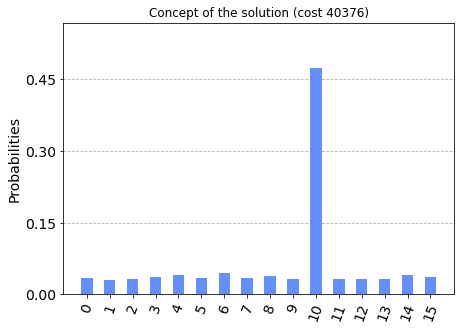

In [22]:
simulate(solution_concept(problem_set), title='Concept of the solution')

As we see, the non-solvable board's amplitude was nicely amplified. The total cost of the solution is, however, far unsatisfying. So the next, more interesting part is dedicated to optimization of the implementation of this idea.

# Optimizing

In [23]:
def costs_table(qcs):
    return HTML(
        '<table><tr><th style="border-top: none; border-left: none"></th><th>Cost</th></tr>' +
        ''.join(f'<tr><td>{name}</td><td style="text-align:right">{compute_cost(qc)}</td></tr>' for name, qc in qcs.items()) +
        '</table>')

## Margolus gate

As the solution is mainly based on the Boolean logic, one of the basic operations we apply in our circuit all the time is CCX (Toffoli) gate. Below we see its standard implementation, which uses 6 CX gates (this is the optimum).

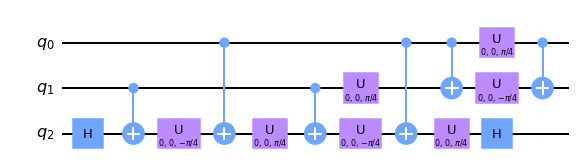

In [24]:
qc_ccx = QuantumCircuit(3)
qc_ccx.ccx(0,1,2)
display_circuit(qc_ccx, unroll=True)

That really costs a lot, making in fact CCX count in our circuit main contribution to the sum. However, there is a better alternative. *Qiskit* provides `rccx` – being relative CCX gate. Its cost is reduced to only 3 CX! But it has a major disadvantage: its relativeness means that it may (and actually does) change the phase of some states.

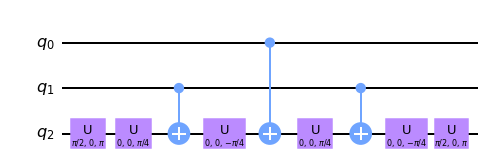

In [25]:
qc_rccx = QuantumCircuit(3)
qc_rccx.rccx(0,1,2)
display_circuit(qc_rccx, unroll=True)

Examining its unitary matrix, we can conclude that it is 2-nd root of unity, and control bits are not treated equally, i.e. `rccx(a, b, c) != rccx(b, a, c)`. Because of that, we need to track carefully our `rccx` gate applications, especially whether the phase is properly uncomputed. For simple enough cases, however, it just works.

In [26]:
print_unitary(qc_rccx)

1,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0
0,0,1,0,0,0,0,0
0,0,0,1,0,0,0,0
0,0,0,0,1,0,0,0
0,0,0,0,0,-1,0,0
0,0,0,0,0,0,0,-i
0,0,0,0,0,0,i,0


As I'm more used to *Margolus gate*, further parts will be based on it. Margolus has very similar properties, being also the second root of unity. The effective unitary is different though – a bit simpler. The methods described later can be used in the same way regardless of `rccx` vs Margolus choice.

In the gate implementation, we introduce a concept of `right_open` and `left_open` to suppress emiting left and/or right one-qubit gates that might get cancelled when applying this gate to the same target.

In [27]:
def mrg(qc, q0, q1, q2, mask=(True, True),
        left_open=False, right_open=False, right_cut=False):
    
    if not left_open:
        qc.ry(pi/4, q2)
    qc.cx(q1, q2)
    
    if mask[1]:
        qc.ry(pi/4, q2)
    else:
        # qc.x(q2)        
        # qc.ry(pi/4, q2)
        qc.u3(3/4*pi, pi, 0, q2)
    
    qc.cx(q0, q2)
    
    if not right_cut:
    
        if mask == (True, True):
            qc.ry(-pi/4, q2)
        elif mask == (True, False):        
            # qc.ry(-pi/4, q2)
            # qc.x(q2)
            qc.u3(3/4*pi, -pi, 0, q2)
        elif mask == (False, True):
            # qc.x(q2)    
            # qc.ry(-pi/4, q2)
            qc.u3(3/4*pi, 0, pi, q2)
        elif mask == (False, False):
            # qc.x(q2)    
            # qc.ry(-pi/4, q2)
            # qc.x(q2)
            qc.u3(1/4*pi, 0, 0, q2)

        qc.cx(q1, q2)

        if not right_open:
            qc.ry(-pi/4, q2)   

The circuit implementation is very similar to `rccx`.

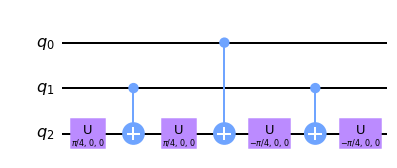

In [28]:
qc_mrg = QuantumCircuit(3)
mrg(qc_mrg, 0, 1, 2)
display_circuit(qc_mrg, unroll=True)

It changes the phase of one state only.

In [29]:
print_unitary(qc_mrg)

1,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0
0,0,1,0,0,0,0,0
0,0,0,1,0,0,0,0
0,0,0,0,1,0,0,0
0,0,0,0,0,-1,0,0
0,0,0,0,0,0,0,1
0,0,0,0,0,0,1,0


The table summarizes the cost of single `CCX`-like gate call. The cost of `rccx` can be easily reduced to match Margolus, merging first and last pair of its one-qubit gates.

In [30]:
costs_table({'ccx': qc_ccx, 'rccx': qc_rccx, 'mrg': qc_mrg})

,Cost
ccx,69
rccx,36
mrg,34


### Anti-controlled version
Moreover, we also used the optimization for anti-controlled versions (parameter `mask`). A standard approach is to negate temporarily the control bit, which adds gates:

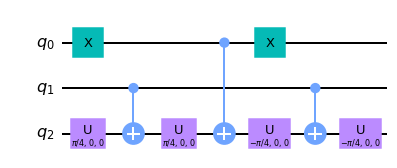

In [31]:
qc_mrg_x = QuantumCircuit(3)
qc_mrg_x.x(0)
mrg(qc_mrg_x, 0, 1, 2)
qc_mrg_x.x(0)
display_circuit(qc_mrg_x, unroll=True)

Happily, this negation of a control bit can be succesfully moved to the target bit, merging with already present there one-qubit gate. Such implementation gives no extra overhead for anti-controlled versions of the gate. Here is an example with anti-control on the first bit:

<ipython-input-27-4b9af2a8039b>:28: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qc.u3(3/4*pi, 0, pi, q2)


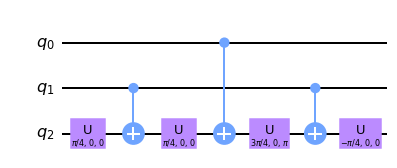

In [32]:
qc_mrg_mask = QuantumCircuit(3)
mrg(qc_mrg_mask, 0, 1, 2, mask=(False, True))
display_circuit(qc_mrg_mask, unroll=True)

Just to confirm two one-qubit gates saving:

In [33]:
costs_table({'qc_mrg_x': qc_mrg_x, 'qc_mrg_mask': qc_mrg_mask})

,Cost
qc_mrg_x,36
qc_mrg_mask,34


### Common control and target
Yet another optimization comes from an observation of what happens if we apply two subsequent Margoluses sharing the target bit and the second control.

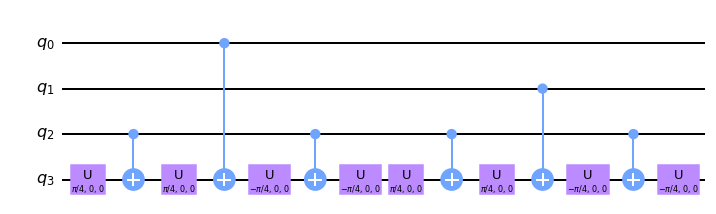

In [34]:
qc_mrg2 = QuantumCircuit(4)
mrg(qc_mrg2, 0, 2, 3)
mrg(qc_mrg2, 1, 2, 3)
display_circuit(qc_mrg2, unroll=True)

Notice that a number of gates in the center of the circuit cancel-out, effectively reducing the count of CX gates. That motivates special implementation of `mrg`, allowing a sequence of first control bit.

In [35]:
def mrg_multi(qc, q0s, q1, q2,
              left_open=False, right_open=False):
    """ More general version of Margolus gate.
    Applies mrg(q0[0], q1, q2), mrg(q0[1], q1, q2), ... """
    
    if not left_open:
        qc.ry(pi/4, q2)
    qc.cx(q1, q2)
    qc.ry(pi/4, q2)
    for q0 in q0s:
        qc.cx(q0, q2)
    qc.ry(-pi/4, q2)
    qc.cx(q1, q2)
    if not right_open:
        qc.ry(-pi/4, q2)

And here is the final result:

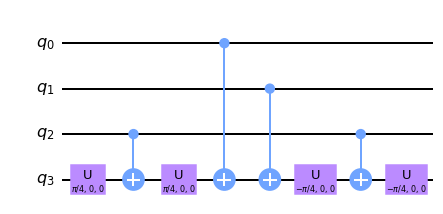

In [36]:
qc_mrg2_multi = QuantumCircuit(4)
mrg_multi(qc_mrg2_multi, (0, 1), 2, 3)
display_circuit(qc_mrg2_multi, unroll=True)

In [37]:
costs_table({'mrg twice': qc_mrg2, 'mrg_multi': qc_mrg2_multi})

,Cost
mrg twice,68
mrg_multi,44


## Inversion realized in quantum

Let us now go back to the formulation of our solution using permutations. Each permutation has its parity – it corresponds to the parity of number of inversions that permutation is made of. Moreover, we can pair all the even permutations with odd ones. For instance we may propose such a pairing that after applying the $(0 1)$ inversion we obtain the second permutation from the pair. Proceeding according to this recipe we obtain the following two sets of permutations:

|Even | Odd |
|---- | ----|
|0123 | 1023|
|0231 | 1230|
|0312 | 1302|
|1320 | 0321|
|1203 | 0213|
|… | … |

The trick we are going to perform is to split each original board into two boards – by introducing yet another Hadamard transoform. For the "odd" copy of the board, during QRAM loading part we will perform this inversion in the quantum state. It is enough to use 4 `CSWAP`s to swap items in two columns. Because of that, later in the oracle we can treat both copies the same way – using only even permutations for checks, as the $(0 1)$ inversion was conditionally preapplied to the second copy.

Effectively now, our search is not over 16 elements, but over 32 elements in total. Each permutation proving unsolvability of the board will be marked by a phase oracle with $\pi$ angle Pauli Z rotation. Amplification by the diffuser follows. Discarding, or even not measuring the added inversion bit, we get the id of the unsolvable board with greater probability than the others.  

By the way, using this technique of splitting permutations into even and odd, we adressed here the problem mentioned earlier with two permutations certifying unsolvability of one board. One can easily prove that if there are two such permutations, these must be of different parity. And more precisely in this case, there is at most one inversion between them.

Here we present applying `CSWAP`s conditioned on the added `qbidi` qubit:

In [38]:
def inverse_concept(qc, qbuf, qbidi):
    assert len(qbuf) == 16
    assert len(qbidi) == 1
    
    for r in range(4):
        a = qbuf[r*4+0]
        b = qbuf[r*4+1]

        qc.cswap(qbidi[0], b, a)

Now we need to modify the `permutations_walk` function to include only the even half of all 24 permutations.

In [39]:
def permutations_walk():
    return [
        (0, 1, 2, 3),
        (0, 2, 3, 1),
        (0, 3, 1, 2),
        (1, 3, 2, 0),
        (1, 2, 0, 3),
        (1, 0, 3, 2),
        (2, 0, 1, 3), 
        (2, 3, 0, 1),
        (2, 1, 3, 0),
        (3, 1, 0, 2),
        (3, 2, 1, 0),
        (3, 0, 2, 1),
    ]

### CSWAP

A bit of optimization can be also applied to the `inverse` function, using Margolus gate instead of `CCX` (in default implemnetation of `CSWAP`).

In [40]:
def inverse(qc, qbuf, qbidi):
    assert len(qbuf) == 16
    assert len(qbidi) == 1
    
    for r in range(4):
        a = qbuf[r*4+0]
        b = qbuf[r*4+1]

        # cswap
        qc.cx(b, a)
        mrg(qc, qbidi[0], a, b)
        qc.cx(b, a)  

We can observe how it reduces the cost of one `inverse` call.

In [41]:
qc_before = QuantumCircuit(17)
inverse_concept(qc_before, Q[0:16], [16])

qc_after = QuantumCircuit(17)
inverse(qc_after, Q[0:16], [16])

costs_table({'before': qc_before, 'after': qc_after})

,Cost
before,356
after,216


## QRAM loading – Gray codes

Finding a good QRAM loader required few hours of manual clicking and moving gates around (as automated tools were disallowed) in [Quirk](https://algassert.com/quirk) – an excellent tool by [Craig Gidney](https://algassert.com).

Here is the [final circuit](https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%22%E2%97%A6%22%2C%22%E2%80%A2%22%2C1%2C1%2C1%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C1%2C%22%E2%97%A6%22%2C1%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C1%2C%22%E2%97%A6%22%2C%22%E2%80%A2%22%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B%22%E2%80%A2%22%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22X%22%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C1%2C%22%E2%97%A6%22%2C%22%E2%80%A2%22%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22X%22%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C%22%E2%97%A6%22%2C1%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C1%2C%22%E2%97%A6%22%2C%22%E2%80%A2%22%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B%22%E2%80%A2%22%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22X%22%2C1%2C%22%E2%80%A2%22%5D%2C%5B1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C1%2C%22%E2%97%A6%22%2C%22%E2%80%A2%22%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22inc1%22%5D%2C%5B1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C1%2C%22%E2%97%A6%22%2C1%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C%22%E2%97%A6%22%2C%22%E2%80%A2%22%2C1%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C1%2C1%2C%22X%22%5D%2C%5B1%2C1%2C1%2C1%2C%22%3C%3C6%22%5D%2C%5B%22Amps5%22%5D%5D%7D).

It utilizes Gray codes sequence to walk over all board ids. But moreover, it turned out that using more than necessary number of ancillae, allowed such distribution of bit swap costs for which the total cost is lower.

Also these ancillae are not uncomputed after completing the pass (`right_open`) – these are specially allocated for this purpose, and we save the cost of uncomputing and recomputing them again during the QRAM unloading.

In the loading stage we will be going from board id `1111` all the way to `0111` (without performing the last bit change to go back to `1111`). In the unloading phase we will be going in reverse (we recognize it by `starting` parameter).

The function below just encodes the circuit linked above.

In [42]:
def obtain4_walk(qc, boards, func, qbid, qanc,
                 starting=0b1111, left_open=False, right_open=False,
                 **kwargs):
    assert starting in (0b1111, 0b0111)
    assert len(qanc) >= 5
    
    bid = starting
    if not left_open:
        assert bid == 0b1111        
        open_obtain4_walk(qc, qbid, qanc)
    
    
    for i in range(len(boards)):
        # Encode data for bid
        func(bid, qanc[4])

        # Gray-code walk over the board ids
        if i < 16 - 1:
            swapbit = 0  # 0 - LSB, 3 - MSB
            if (i+1) & 0b0001 == 0: swapbit += 1
            if (i+1) & 0b0011 == 0: swapbit += 1
            if (i+1) & 0b0111 == 0: swapbit += 1

            if swapbit == 0:
                qc.cx(qanc[1], qanc[4])
            elif swapbit == 1:
                qc.cx(qanc[0], qanc[1])
                mrg(qc, qbid[3], qanc[0], qanc[4], mask=(False, True))
            elif swapbit == 2:
                qc.cx(qbid[0], qanc[0])
                qc.cx(qanc[3], qanc[1])
                mrg(qc, qbid[3], qanc[3], qanc[4])
            elif swapbit == 3:
                qc.x(qbid[0])
                qc.cx(qanc[2], qanc[1])
                mrg(qc, qbid[3], qanc[2], qanc[4])
                qc.x(qanc[0])
                qc.cx(qbid[1], qanc[0])
                qc.x(qanc[3])
                qc.cx(qbid[2], qanc[3])

            bid ^= (1 << swapbit)

    assert bid == (0b1000 ^ starting)
    
    if not right_open: 
        close_obtain4_walk(qc, qbid, qanc, **kwargs)           


In [43]:
def open_obtain4_walk(qc, qbid, qanc):           
    mrg(qc, qbid[0], qbid[1], qanc[0])
    mrg(qc, qanc[0], qbid[2], qanc[1])
    mrg(qc, qbid[1], qbid[2], qanc[2], mask=(False, True))
    mrg(qc, qbid[0], qbid[2], qanc[3], mask=(True, False))
    mrg(qc, qbid[3], qanc[1], qanc[4])

In [44]:
def close_obtain4_walk(qc, qbid, qanc,
                       small_diffuser=False, last_minute_opt=False):    
    mrg(qc, qbid[3], qanc[1], qanc[4],
        right_open=True, right_cut=last_minute_opt)
    mrg(qc, qbid[0], qbid[2], qanc[3],
        right_open=True, mask=(True, False), right_cut=small_diffuser)
    if not small_diffuser:
        mrg(qc, qbid[1], qbid[2], qanc[2],
            right_open=True, mask=(False, True))
    mrg(qc, qanc[0], qbid[2], qanc[1],
        right_open=True, right_cut=small_diffuser)
    mrg(qc, qbid[0], qbid[1], qanc[0],
        right_open=True, right_cut=small_diffuser)

For the `close_obtain4_walk` let us ignore the additional flags for a while (this will be explained later).

In [45]:
def obtain4_many(qc, boards, coords, qbid, qbuf, qanc, **kwargs):
    def func(bid, qctrl):
        for (r, c), qtarget in zip(coords, qbuf):
            if boards[bid][r, c]:
                qc.cx(qctrl, qtarget)
    obtain4_walk(qc, boards, func, qbid, qanc, **kwargs)

Now let us examine the cost savings for the whole `obtain4_many` introduced by this optimization.

In [46]:
boards = [read_board(board_spec) for board_spec in problem_set]
coords = [(r, c) for r in range(4) for c in range(4)]

qc_before = QuantumCircuit(21)
obtain4_many_concept(qc_before, boards, coords, Q[:4], Q[4:20], [20])

qc_after = QuantumCircuit(25)
obtain4_many(qc_after, boards, coords, Q[:4], Q[4:20], Q[20:25])

costs_table({'before': qc_before, 'after': qc_after})

,Cost
before,16608
after,1726


### Complete QRAM part

Collecting what we have just discussed.

In [47]:
def qram(qc, inv, boards, qbid, qbidi, qbidanc, qbuf, **kwargs):
    assert len(qbid) == 4
    assert len(qbuf) == 16
    
    def obt(inv):
        obtain4_many(
            qc, boards,
            [(r, c) for r in range(4) for c in range(4)],
            qbid, qbuf, qbidanc,
            left_open=inv, right_open=not inv,
            starting=[0b1111, 0b0111][inv],
            **kwargs
        ) 

    if not inv:
        obt(False)
        inverse(qc, qbuf, qbidi)
    else:
        inverse(qc, qbuf, qbidi)
        obt(True)

Total savings (loading `inv=False` and unloading `inv=True`)

In [48]:
qc_before = QuantumCircuit(21)
qram_concept(qc_before, boards, Q[:4], [4], Q[5:21])
qram_concept(qc_before, boards, Q[:4], [4], Q[5:21])

qc_after = QuantumCircuit(26)
qram(qc_after, False, boards, Q[:4], [4], Q[5:10], Q[10:26])
qram(qc_after, True, boards, Q[:4], [4], Q[5:10], Q[10:26])

costs_table({'before': qc_before, 'after': qc_after})

,Cost
before,33216
after,3549


## Mark unsolvable

Here there are a few optimizations to make.


### Use Margolus extensively

First of all, we use a specific ordering of permutations in `permutations_walk`:

In [49]:
permutations_walk()

[(0, 1, 2, 3),
 (0, 2, 3, 1),
 (0, 3, 1, 2),
 (1, 3, 2, 0),
 (1, 2, 0, 3),
 (1, 0, 3, 2),
 (2, 0, 1, 3),
 (2, 3, 0, 1),
 (2, 1, 3, 0),
 (3, 1, 0, 2),
 (3, 2, 1, 0),
 (3, 0, 2, 1)]

It was choosen in such a way that either first or the second element of the permutation is kept unchanged between two subsequent permutations (first pair). As a consequence, two remaining elements keep changing with no common elements (second pair). We can benefit from the behavior of the first pair. Examine the first transition from `(0, 1, …)` to `(0, 2, …)`. We are `CCX`-ing the ancilla with the presence of asteroids at the first two positions.

Normally, we would first have to unload the first pair, and then load the second one:

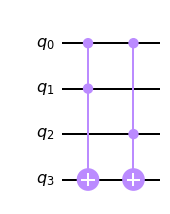

In [50]:
qc_swap_pairs = QuantumCircuit(4)
qc_swap_pairs.ccx(0, 1, 3)
qc_swap_pairs.ccx(0, 2, 3)
display_circuit(qc_swap_pairs)

But we recognize a pattern of two `CCX`es sharing one control bit, therefore we can apply `mrg_multi` to save extra CX gates.

### Delay T gates from CCZ
The next optimization comes from the decomposition of `CCZ` gate.

In [51]:
def ccz(qc, q0, q1, q2, open_=False):
    if not open_:
        qc.t(q2)
        qc.t(q1) 
        qc.t(q0)
    
    qc.cx(q0, q2); qc.tdg(q2);
    qc.cx(q1, q2); qc.t(q2);
    qc.cx(q0, q2); qc.tdg(q2);
    qc.cx(q1, q2);
    qc.cx(q0, q1); qc.tdg(q1); qc.cx(q0, q1)

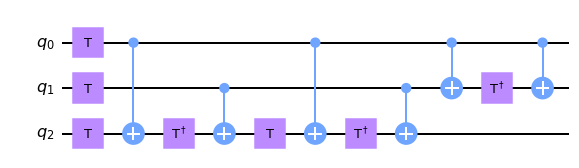

In [52]:
qc_ccz = QuantumCircuit(3)
ccz(qc_ccz, 0, 1, 2)
display_circuit(qc_ccz)

`CCZ` gate is diagonal one.

In [53]:
print_unitary(qc_ccz)

1,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0
0,0,1,0,0,0,0,0
0,0,0,1,0,0,0,0
0,0,0,0,1,0,0,0
0,0,0,0,0,1,0,0
0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,-1


Each of the three `T` gates opening the gate's decomposition is diagonal as well. This means that these all these parts commute with each other, allowing their reorganization. We will use this to delay execution of `T` gates. Two qubits involved in the `CCZ` will be input data, which is used only for these `CCZ`s – therefore we can apply the needed one-qubit operation for qubits needing that, only once for all the permutations.

The third qubit is our working ancilla – used to mark the appearance of the first pair. We need to apply that `T` gate immediately – the best is to merge it with closing one-qubit gate of Margolus.

In [54]:
def close_mrg_and_t(qc, q):
    # qc.ry(-pi/4, q)
    # qc.t(q)
    qc.u3(-pi/4, pi/4, 0, q)

This is the complete version of `mark_unsolvable` part.

In [55]:
def mark_unsolvable(qc, qbuf, qanc):
    assert len(qbuf) == 16
    assert len(qanc) >= 1
    
    t_count = [0] * 16 # How many times to apply T gate to the buffer?

    permwalk = permutations_walk()
    for pid, perm in enumerate(permwalk):   
        if pid > 0:
            prev = permwalk[pid-1]
            # Swap-load first pair
            if perm[0] == prev[0]:
                mrg_multi(qc, (qbuf[1*4 + perm[1]], qbuf[1*4 + prev[1]]),
                          qbuf[0*4 + perm[0]], qanc[0], right_open=True)
            elif perm[1] == prev[1]:
                mrg_multi(qc, (qbuf[0*4 + perm[0]], qbuf[0*4 + prev[0]]),
                          qbuf[1*4 + perm[1]], qanc[0], right_open=True)
            else:
                assert False
        else:
            # Just load first pair for the first time
            mrg(qc, qbuf[0*4 + perm[0]], qbuf[1*4 + perm[1]], qanc[0], right_open=True)

        # Use second pair and qanc[0] to perform action!
        x = 2*4 + perm[2]
        y = 3*4 + perm[3]

        # CCZ parts
        t_count[x] += 1
        t_count[y] += 1
        close_mrg_and_t(qc, qanc[0])
        
        ccz(qc, qbuf[x], qbuf[y], qanc[0], open_=True)


        if pid == 12 - 1:
            # Unload on last iteration
            mrg(qc, qbuf[0*4 + perm[0]], qbuf[1*4 + perm[1]], qanc[0])

    # Apply the outstanding T gates
    for i in range(16):
        if t_count[i] % 8 != 0:
            qc.u1(pi/4 * t_count[i], qbuf[i])

Halving the number of permutations and applying Margolus gates gives yet another score reduction of `mark_unsolvable` routine.

In [56]:
qc_before = QuantumCircuit(18)
mark_unsolvable_concept(qc_before, Q[:16], Q[16:18])

qc_after = QuantumCircuit(18)
mark_unsolvable(qc_after, Q[:16], Q[16:18])

costs_table({'before': qc_before, 'after': qc_after})

<ipython-input-55-bbe1d4ce1b6a>:43: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(pi/4 * t_count[i], qbuf[i])


,Cost
before,6912
after,1328


## Diffusion operator

Our search space containing $2^5 = 32$ states is spanned on $5$ qubits. Therefore to amplify the ones with altered phase, we need to construct 5-qubit diffuser. According to the original recipe, the diffusion operator is realized by the following circuit.

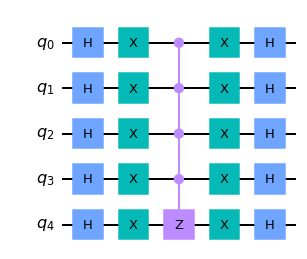

In [57]:
def diffusion5_concept(qc, qbits):
    qc.h(qbits)
    qc.x(qbits)
    qc.append(ZGate().control(len(qbits) - 1), qbits)
    qc.x(qbits)
    qc.h(qbits)
    
qc = QuantumCircuit(5)
diffusion5_concept(qc, Q[:5])
display_circuit(qc)

The cost of `CCCCZ` is, however, quite high. Let us use two ancillae to lower the cost:

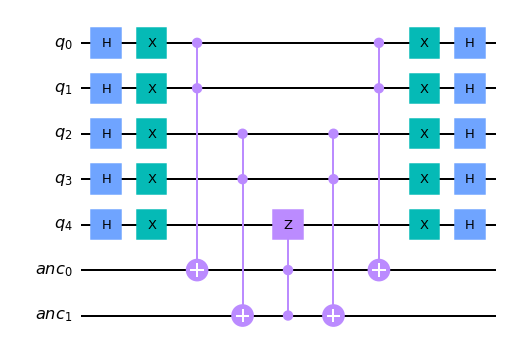

In [58]:
def diffusion5_simple(qc, qbits, qanc):    
    qc.h(qbits)
    qc.x(qbits)  
    
    qc.ccx(qbits[0], qbits[1], qanc[0])    
    qc.ccx(qbits[2], qbits[3], qanc[1])
    qc.append(ZGate().control(2), [qanc[0], qanc[1], qbits[4]]) 
    qc.ccx(qbits[2], qbits[3], qanc[1])
    qc.ccx(qbits[0], qbits[1], qanc[0]) 
    
    qc.x(qbits)
    qc.h(qbits)
    
q = QuantumRegister(5, name='q')
qanc = QuantumRegister(2, name='anc')
qc = QuantumCircuit(q, qanc)
diffusion5_simple(qc, q, qanc)
display_circuit(qc)

Finally, let's calculate the product of `H` and `X` gate (and its inverse), used in the diffuser to merge a few one-qubit gates.

In [59]:
def hx(qc, q):
    qc.u3(pi/2, 0, 0, q) 
    
def xh(qc, q):
    qc.u3(-pi/2, 0, 0, q)

In [60]:
def diffusion5(qc, qbits, qanc):
    assert len(qbits) == 5
    assert len(qanc) >= 2
    
    hx(qc, qbits)

    mrg(qc, qbits[0], qbits[1], qanc[0])
    mrg(qc, qbits[2], qbits[3], qanc[1])
    ccz(qc, qanc[0], qanc[1], qbits[4])
    mrg(qc, qbits[2], qbits[3], qanc[1])
    mrg(qc, qbits[0], qbits[1], qanc[0])

    xh(qc, qbits)

That gives us the following cost reduction for 5-qubit diffuser.

In [61]:
qc_diffuser5_before = QuantumCircuit(5)
diffusion5_concept(qc_diffuser5_before, Q[:5])

qc_diffuser5_after = QuantumCircuit(7)
diffusion5(qc_diffuser5_after, Q[:5], Q[5:7])

costs_table({'before': qc_diffuser5_before, 'after': qc_diffuser5_after})

,Cost
before,520
after,213


### Small diffusion operator

It turns out, that such a big diffuser is not necessarily needed to get the amplification.
One can use a smaller one.
For more than one iteration of Grover it is quite tricky to arrange right sets of qubits used for diffusion.
You can read about it more in our [publication about introducing structure to expedite quantum search](https://arxiv.org/abs/2006.05828).
In our case, limited to one iteration, we can just apply the smallest sensible diffuser, namely the 2-qubit one.
The amplification will be performed in 4-element subspaces defined by all the remaining qubits' values.

In [62]:
def diffusion2(qc, qbits):
    assert len(qbits) == 2
    
    hx(qc, qbits[0])
    qc.z(qbits[1]) #HXH
    qc.cx(qbits[0], qbits[1])
    qc.z(qbits[1]) #HXH
    xh(qc, qbits[0])

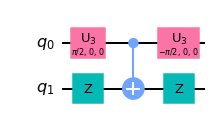

In [63]:
qc_diffuser2 = QuantumCircuit(2)
diffusion2(qc_diffuser2, Q[:2])
display_circuit(qc_diffuser2)

Let us now summarize the cost savings for the diffuser.

In [64]:
costs_table({
    'concept (5q)': qc_diffuser5_before,
    'optimized (5q)': qc_diffuser5_after,
    'small (2q)': qc_diffuser2
})

,Cost
concept (5q),520
optimized (5q),213
small (2q),14


The remaining decision to make is which of the qubits to use for diffusion in small diffuser setting. It strongly depends on the `obtain4_walk` implementation – especially the connections between board id qubits and the corresponding ancillae. We don't need to uncompute all the qubits used for obtaining data, those which don't interact with the diffuser have no impact on the measurement results. Our choice here is for 0th and 3rd qubit of the address.

We cannot choose the new `qbidi` qubit for small diffusion, as in case of two permutations marked per board, we would get no amplification for 2 out of 4 elements being marked. 

In [65]:
def diffuser(qc, qbid, qbidi, qanc, small_diffuser):
    assert len(qbid) == 4
    assert len(qbidi) == 1
    
    if small_diffuser:
        diffusion2(qc, [qbid[0], qbid[3]])
    else:
        diffusion5(qc, qbid[:] + [qbidi[0]], qanc)

## Complete solution

The code that integrates all the parts of our optimized version.

In [66]:
def oracle(qc, boards, qbid, qbidi, qbidanc, qbuf, qanc, **kwargs):  
    qram(qc, False, boards, qbid, qbidi, qbidanc, qbuf, **kwargs)        
    mark_unsolvable(qc, qbuf, qanc)
    qram(qc, True, boards, qbid, qbidi, qbidanc, qbuf, **kwargs)

In [67]:
def solution(problem_set, small_diffuser=False, last_minute_opt=False):
    boards = [read_board(board_spec) for board_spec in problem_set]
    
    # Board id [0 - MSB, 3 - LSB]      
    qbid = QuantumRegister(4, name='bid')
    
    # Whether the inversion is applied 
    qbidi = QuantumRegister(1, name='bidi') 
    
    # Ancillae exclusively for loader
    qbidanc = QuantumRegister(5, name='bidanc')
    
    # Buffer for the whole board (flattened, C memory order)
    qbuf = QuantumRegister(16, name='buf') 
    
    # General-purpose ancillae
    qanc = QuantumRegister(2, name='anc')
    
    # Measured answer (endianness as in `qbid`)
    cans = ClassicalRegister(4, name='c')

    qc = QuantumCircuit(
        qbidi, qbid, qbidanc, qbuf,
        qanc,
        cans,
    )                
        
    # Initial superposition
    qc.h(qbid)
    qc.h(qbidi)
    
    oracle(qc, boards, qbid, qbidi, qbidanc, qbuf, qanc,
           small_diffuser=small_diffuser,
           last_minute_opt=last_minute_opt)
    
    diffuser(qc, qbid, qbidi, qanc,
             small_diffuser=small_diffuser)

    qc.measure(qbid, cans)
        
    return qc

## Optimization results

Here is the summary of the solutions submitted.

In [68]:
qc = solution(problem_set)
print('Operations:', qc.count_ops())
print('Cost:', compute_cost(qc))

Operations: OrderedDict([('cx', 482), ('ry', 165), ('tdg', 39), ('u3', 36), ('t', 16), ('u1', 8), ('x', 6), ('h', 5), ('measure', 4)])
Cost: 5095


In [69]:
qc = solution(problem_set, small_diffuser=True)
print('Operations:', qc.count_ops())
print('Cost:', compute_cost(qc))

Operations: OrderedDict([('cx', 459), ('ry', 145), ('tdg', 36), ('u3', 26), ('t', 12), ('u1', 8), ('x', 6), ('h', 5), ('measure', 4), ('z', 2)])
Cost: 4830


### Simulation
To confirm we didn't break anything.

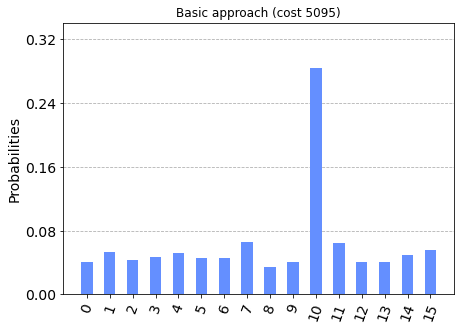

In [70]:
simulate(solution(problem_set), title='Basic approach')

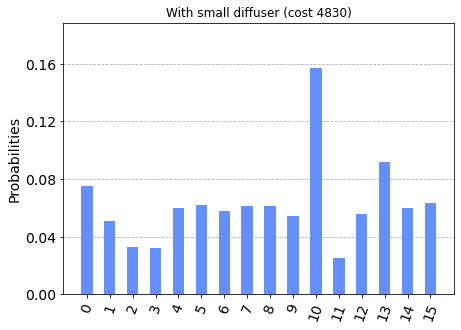

In [71]:
simulate(
    solution(problem_set, small_diffuser=True),
    title='With small diffuser')

In the histogram above we observe, that due to use of 2-qubit diffuser, the additional amplitude of board 10 (1010 binary) comes from boards 2, 3, 11 (0010, 0011, 1011 binary) – which is consistent with our expectations.

In the last hour of the contest I accidentally removed yet another gate. Since it worked for the example dataset, I made an extra submission. Given that I had no time to verify its correctess at that time, I left the final verdict to the Jury.

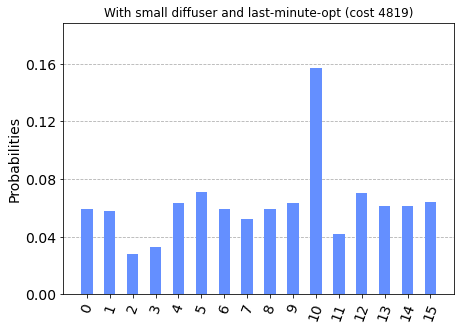

In [72]:
simulate(
    solution(problem_set, small_diffuser=True, last_minute_opt=True),
    title='With small diffuser and last-minute-opt')

# Closing words

This write-up presents the algorithm used for my contest submission.
Further improvements are likely possible – both exploring further the optimizations mentioned, but also involving other techniques.
For instance, the data transfer into quantum system could be a subject of compression.
Even more ideas for optimization and different approaches could be found in the [top 10 participants' write-ups](https://github.com/qiskit-community/IBMQuantumChallenge2020/tree/main/submissions).

At [BEIT](https://beit.tech) we do a lot like this, trying to get the most out of the currently available hardware – where each additional gate counts towards reduced circuit fidelity.
Recently we published two papers on our experimental results on the unstructured search utilizing the mentioned before [small diffusors technique](https://arxiv.org/abs/2006.05828):

- [4-qubit search on the IBM's machine](https://arxiv.org/abs/2007.06539)
- [4,5,6-qubit search on the Honeywell's machine](https://arxiv.org/abs/2010.03841)